In [11]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #sklearn xgboost  #Additional     scklearn functions  #Perforing grid search
from sklearn.decomposition import PCA
import scipy.io as sio
import numpy as np
import torch.optim as optim
from operator import truediv
from sklearn.metrics import cohen_kappa_score
import spectral

In [12]:
from sklearn.metrics import accuracy_score
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc
def reports (y_pred,y_test):
    """
    定量分析
    """
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return  confusion, oa*100, each_acc*100, aa*100, kappa*100


In [13]:
# 通道注意力机制
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
 
        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)
 
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)
# 空间注意力机制
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
 
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
 
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
 
# 网络骨架
class HybridSN(nn.Module):
    def __init__(self, num_classes = 9, self_attention=False):
        super(HybridSN, self).__init__()
        # out = (width - kernel_size + 2*padding)/stride + 1
        # => padding = ( stride * (out-1) + kernel_size - width)
        # 这里因为 stride == 1 所有卷积计算得到的padding都为 0
 
        #默认不使用注意力机制
        self.self_attention = self_attention
 
        # 3D卷积块
        self.block_1_3D = nn.Sequential(
            nn.Conv3d(
                in_channels=1,
                out_channels=8,
                kernel_size=(7, 3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                in_channels=8,
                out_channels=16,
                kernel_size=(5, 3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                in_channels=16,
                out_channels=32,
                kernel_size=(3, 3, 3),
                stride=1,
                padding=0
            ),
            nn.ReLU(inplace=True)
        )
       
        if self_attention:
            self.channel_attention_1 = ChannelAttention(256)
            self.spatial_attention_1 = SpatialAttention(kernel_size=7)
 
        # 2D卷积块
        self.block_2_2D = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=64,
                kernel_size=(3, 3)
            ),
            nn.ReLU(inplace=True)
        )
 
        if self_attention:
            self.channel_attention_2 = ChannelAttention(64)
            self.spatial_attention_2 = SpatialAttention(kernel_size=7)
 
        # 全连接层
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=576,
                out_features=256
            ),
            nn.Dropout(p=0.4),
            nn.Linear(
                in_features=256,
                out_features=128
            ),
            nn.Dropout(p=0.4),
            nn.Linear(
                in_features=128,
                out_features=num_classes
            )
            # pytorch交叉熵损失函数是混合了softmax的。不需要再使用softmax
        )
    def forward(self, x):
        y = self.block_1_3D(x)
        y = y.view(-1, y.shape[1] * y.shape[2], y.shape[3], y.shape[4])

        if self.self_attention:
            y = self.channel_attention_1(y) * y
            y = self.spatial_attention_1(y) * y
     
        y = self.block_2_2D(y)
        if self.self_attention:
            y = self.channel_attention_2(y) * y
            y = self.spatial_attention_2(y) * y
     
        y = y.view(y.size(0), -1)
 
        y = self.classifier(y)
        return y


In [14]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test


Hyperspectral data shape:  (610, 340, 103)
Label shape:  (610, 340)

... ... PCA tranformation ... ...
Data shape after PCA:  (610, 340, 20)

... ... create data cubes ... ...
Data cube X shape:  (42776, 11, 11, 20)
Data cube y shape:  (42776,)

... ... create train & test data ... ...
Xtrain shape:  (21388, 11, 11, 20)
Xtest  shape:  (21388, 11, 11, 20)
before transpose: Xtrain shape:  (21388, 11, 11, 20, 1)
before transpose: Xtest  shape:  (21388, 11, 11, 20, 1)
after transpose: Xtrain shape:  (21388, 1, 20, 11, 11)
after transpose: Xtest  shape:  (21388, 1, 20, 11, 11)
[Epoch: 1]   [loss avg: 79.0023]   [current loss: 0.0568]
[Epoch: 2]   [loss avg: 43.8823]   [current loss: 0.0003]
[Epoch: 3]   [loss avg: 31.0616]   [current loss: 0.0002]
[Epoch: 4]   [loss avg: 24.4614]   [current loss: 0.0004]
[Epoch: 5]   [loss avg: 20.0913]   [current loss: 0.0085]
[Epoch: 6]   [loss avg: 16.9684]   [current loss: 0.0013]
[Epoch: 7]   [loss avg: 15.1104]   [current loss: 0.0507]
[Epoch: 8]   [l

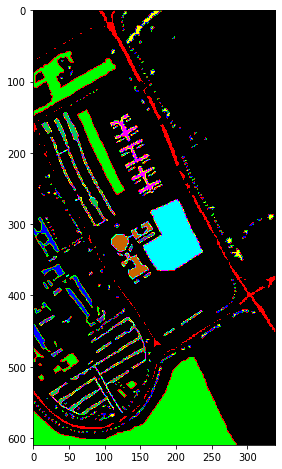

In [20]:
# 地物类别
class_num = 9
X = sio.loadmat(r'C:/Users/87758/Desktop/Project_final/Dataset_Image_University.mat')['DataTest']
y = sio.loadmat(r'C:/Users/87758/Desktop/Project_final/University_groundtruth_map.mat')['map']
X = np.array(X).reshape(610,340,103)
y = np.array(y).reshape(610,340)
# 用于测试样本的比例

# 每个像素周围提取 patch 的尺寸
patch_size = 11
# 使用 PCA 降维，得到主成分的数量
pca_components = 20

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

size = [0.50]
result = []
each_acc_result = []
for item in size:
    print('\n... ... create train & test data ... ...')
    Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, item)
    print('Xtrain shape: ', Xtrain.shape)
    print('Xtest  shape: ', Xtest.shape)

    # 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
    Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
    Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
    print('before transpose: Xtrain shape: ', Xtrain.shape) 
    print('before transpose: Xtest  shape: ', Xtest.shape) 

    # 为了适应 pytorch 结构，数据要做 transpose
    Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
    Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
    print('after transpose: Xtrain shape: ', Xtrain.shape) 
    print('after transpose: Xtest  shape: ', Xtest.shape) 


    """ Training dataset"""
    class TrainDS(torch.utils.data.Dataset): 
        def __init__(self):
            self.len = Xtrain.shape[0]
            self.x_data = torch.FloatTensor(Xtrain)
            self.y_data = torch.LongTensor(ytrain)        
        def __getitem__(self, index):
            # 根据索引返回数据和对应的标签
            return self.x_data[index], self.y_data[index]
        def __len__(self): 
            # 返回文件数据的数目
            return self.len

    """ Testing dataset"""
    class TestDS(torch.utils.data.Dataset): 
        def __init__(self):
            self.len = Xtest.shape[0]
            self.x_data = torch.FloatTensor(Xtest)
            self.y_data = torch.LongTensor(ytest)
        def __getitem__(self, index):
            # 根据索引返回数据和对应的标签
            return self.x_data[index], self.y_data[index]
        def __len__(self): 
            # 返回文件数据的数目
            return self.len

    # 创建 trainloader 和 testloader
    trainset = TrainDS()
    testset  = TestDS()
    train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=0)
    test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=0)
    # 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 网络放到GPU上
    net = HybridSN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # 开始训练
    total_loss = 0
    for epoch in range(60):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # 优化器梯度归零
            optimizer.zero_grad()
            # 正向传播 +　反向传播 + 优化 
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))

    print('Finished Training')
    count = 0
    # 模型测试
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred_test =  outputs
            count = 1
        else:
            y_pred_test = np.concatenate( (y_pred_test, outputs) )

    # 生成分类报告
    confusion, oa, each_acc, aa, kappa  = reports(ytest, y_pred_test)
    middle_dict ={'oa':round(oa,5),'aa':round(aa,5),'kappa':round(kappa,5),'Tr':item}
    result.append(middle_dict)
    each_acc_result.append(each_acc)
    # load the original image

   
    X = sio.loadmat(r'C:/Users/87758/Desktop/Project_final/Dataset_Image_University.mat')['DataTest']
    y = sio.loadmat(r'C:/Users/87758/Desktop/Project_final/University_groundtruth_map.mat')['map']
    X = np.array(X).reshape(610,340,103)
    y = np.array(y).reshape(610,340)
    height =y.shape[0]
    width = y.shape[1] 
    X = applyPCA(X, numComponents= pca_components)
    X = padWithZeros(X, patch_size//2)

    # 逐像素预测类别
    outputs = np.zeros((height,width))
    for i in range(height):
        for j in range(width):
            if int(y[i,j]) == 0:
                continue
            else :
                image_patch = X[i:i+patch_size, j:j+patch_size, :]
                image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
                X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)                                   
                prediction = net(X_test_image)
                prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
                outputs[i][j] = prediction+1
        if i % 20 == 0:
            print('... ... row ', i, ' handling ... ...')
    predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(8,8))


In [7]:
pd.DataFrame(result)

NameError: name 'pd' is not defined

In [8]:
import pandas as pd

In [10]:
pd.DataFrame(result).to_csv('deep_learning.csv')

In [14]:
pd.DataFrame(each_acc_result).applymap(lambda x:round(x,5)).to_csv('DL_acc.csv')

In [17]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = HybridSN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 开始训练
total_loss = 0
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))

print('Finished Training')
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
confusion, oa, each_acc, aa, kappa  = reports(ytest, y_pred_test)


torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 3]   [loss avg: 29.1348]   [current loss: 0.2014]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 6]   [loss avg: 16.4708]   [current loss: 0.0420]

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 20]   [loss avg: 5.4396]   [current loss: 0.0077]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 23]   [loss avg: 4.7817]   [current loss: 0.0041]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])

torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5]

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 37]   [loss avg: 3.1110]   [current loss: 0.0000]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])

torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 40]   [loss avg: 2.8793]   [current loss: 0.0000]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])

torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3

torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3

torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3

torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 54]   [loss avg: 2.1338]   [current loss: 0.0000]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])

torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 57]   [loss avg: 2.0215]   [current loss: 0.0000]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5]

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([53, 64, 3, 3])
[Epoch: 71]   [loss avg: 1.7898]   [current loss: 0.0247]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5

torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 74]   [loss avg: 1.7355]   [current loss: 0.0008]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 88]   [loss avg: 1.4682]   [current loss: 0.0000]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([53, 256, 5, 5])
torch.Size([53, 256, 5, 5])
torch.Size([53, 64, 3, 3])
[Epoch: 91]   [loss avg: 1.4200]   [current loss: 0.0005]
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])

torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5

torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

In [6]:
from sklearn.metrics import accuracy_score
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc
def reports (y_pred,y_test):
    """
    定量分析
    """
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return  confusion, oa*100, each_acc*100, aa*100, kappa*100


In [26]:
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
confusion, oa, each_acc, aa, kappa  = reports(ytest, y_pred_test)

torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 

torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5

torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5])
torch.Size([128, 256, 5, 5])
torch.Size([128, 64, 3, 3])
torch.Size([128, 256, 5, 5

In [27]:
each_acc

array([ 99.93262591,  99.90474489,  98.22866345,  99.78126139,
       100.        ,  99.93376021,  99.74979149,  97.24035608,
       100.        ])